# Attempts to quantify SIT variability

### Prep

In [138]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import scipy.signal as signal
import scipy.stats as stats
import statsmodels.tsa.seasonal as sm_seasonal
import statsmodels.tsa.stattools as tsa_stats

#### Defined Functions

In [2]:
## Processing 
def read_cmip_files(cat, variable):
    cmip_dir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/'+cat+'/'+variable+'/gn/files/d20190320/'
    files = sorted(glob.glob(cmip_dir+variable+'_'+cat+'_CESM2_piControl_r1i1p1f1_gn_*[0-9]*'))
    cmip_ds = xr.open_mfdataset(files[-2:-1], combine='by_coords')
    return cmip_ds

def read_cesmLE(variable):
    arrays = []
    for i in range(1,11):
        files = sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/month_1/'+variable+'/b.e21.BHISTcmip6.f09_g17.LE2-1*[0-9]*.0{:0>2d}.*[0-9]*.nc'.format(i)))
        
        array_group = xr.open_mfdataset(files, combine='by_coords')
        
        arrays.append(array_group)
        
    final_array = xr.concat(arrays, dim = 'ensemble_member')
    return final_array

def annual_variance_per_month(array):
    # detrend array
    detrended_array = signal.detrend(array.fillna(0), axis = 0, type = "linear")
    
    # convert back to DataArray and replace zeros w nans 
    detrended_DataArray = xr.DataArray(detrended_array, coords=array.coords, dims=array.dims, attrs=array.attrs)
    detrended_DataArray = detrended_DataArray.where(detrended_array > 0)
    
    # group by month and calculate standard deviation
    variance_grid = detrended_DataArray.groupby('time.month').var(dim = 'time', ddof=1)
    
    return variance_grid

def annual_variance_per_season(array):
    # detrend array
    detrended_array = signal.detrend(array.fillna(0), axis = 0, type = "linear")
    
    # convert back to DataArray and replace zeros w nans 
    detrended_DataArray = xr.DataArray(detrended_array, coords=array.coords, dims=array.dims, attrs=array.attrs)
    detrended_DataArray = detrended_DataArray.where(detrended_array > 0)
    
    # group by month and calculate standard deviation
    variance_grid = detrended_DataArray.groupby('time.season').var(dim = 'time', ddof=1)
    # variance_grid_std = variance_grid/detrended_DataArray.groupby('time.season').mean(dim='time')
    
    return variance_grid


## Plotting 
def convert_coords(lat, lon, og_data, ccrs_grid):
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

# Plotting functions 
def fashion_space(ax):
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
def plot_nps(data_array, bounds, cmap):
    data = data_array
    lat = data_array.lat
    lon = data_array.lon
    nps = ccrs.NorthPolarStereo()
    
    xs,ys,plot_data=convert_coords(lat, lon, data, nps)
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.axes(projection=nps)
    fashion_space(ax)
    # cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(bounds[0], bounds[1], 11)
    clevs = np.linspace(bounds[0], bounds[1], 21)
    img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

#### Load Data

In [3]:
cmip_mon_hi = read_cmip_files('SImon','sithick')
cmip_day_hi = read_cmip_files('SIday','sithick')
cmip_mon_vol = read_cmip_files('SImon','sivol')

cmip_day_aice = read_cmip_files('SIday','siconc')

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sivol' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


### Markov Model thing

In [4]:
cmip_day_voln = cmip_day_hi.sithick * cmip_day_aice.siconc/100

In [5]:
# cmip_day_vol = cmip_day_voln[:,355,193]
# cmip_day_vol = cmip_day_voln[:,375,50]

In [6]:
cmip_day_vol = cmip_day_voln[0:3650,:,:].compute()

#### Deasonalize

In [385]:
anom_vol = cmip_day_vol.diff(dim='time',n=1)

In [361]:
# anom_vol = cmip_day_vol.diff(dim='time',n=1).groupby('time.season')['DJF']

In [362]:
# winter_anom_vol

In [363]:
# plt.plot(cmip_day_vol)

In [364]:
# import statsmodels.tsa as smt
# A = smt.stattools.acf(cmip_day_vol, nlags = 1, missing='drop')

In [386]:
day_n = anom_vol[1:,:,:]#.fillna(0)
day_np1 = anom_vol[0:-1,:,:]#.fillna(0)

In [387]:
import esmtools.stats as esmstat
A = esmstat.autocorr(anom_vol, dim = 'time', nlags = 2)

In [388]:
# A = xr.corr(day_np1, day_n, dim = 'time')

In [389]:
# A[1]

In [390]:
# A[1] = A[1].fillna(1)

In [391]:
external = day_n - A[1]*day_np1

In [392]:
ext_sq = external**2

In [393]:
variance = 1/(len(ext_sq)-1) * ext_sq.sum(dim = 'time', skipna = True)

In [394]:
ratio = 100*variance/(1-A[1])

In [395]:
ratio

<xarray.DataArray (nj: 384, ni: 320)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [19.510098, 19.200762, 35.613537, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    lat      (nj, ni) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    lon      (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
  * ni       (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj       (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384

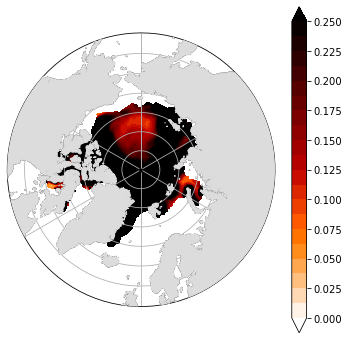

In [396]:
plot_nps(ratio, [0,0.25], plt.cm.gist_heat_r)

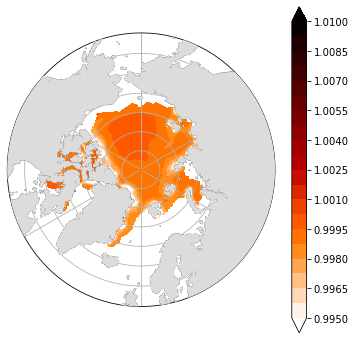

In [404]:
plot_nps(A[1], [0.995,1.01], plt.cm.gist_heat_r)

In [398]:
A[1]

<xarray.DataArray (nj: 384, ni: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.9997426 , 0.99969894, 0.9995076 , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    lat      (nj, ni) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    lon      (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
  * ni       (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj       (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384

### Monthly Analysis

Start by looking at a single grid cell. Visualize the timeseries.

In [3]:
CESMLE = read_cesmLE('vicen')

In [4]:
cesmle_vol = CESMLE.vicen.mean(dim = 'ensemble_member')

In [68]:
cat1_test = cesmle_vol[:,0, 355,193]
cat1_test

<xarray.DataArray 'vicen' (time: 1980)>
dask.array<getitem, shape=(1980,), dtype=float32, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
    TLON     float32 201.8
    TLAT     float32 79.91
    ULON     float32 203.5
    ULAT     float32 80.08
    NCAT     float32 0.6445
  * time     (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00

#### detrend with polynomial fit

In [19]:
time = np.arange(0, len(cat1_test.time))
test_set_fit = np.polyfit(time, cat1_test, 9)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [20]:
test_set_fit

array([ 1.10090354e-27, -9.52557438e-24,  3.40708809e-20, -6.51616450e-17,
        7.21413533e-14, -4.69878100e-11,  1.77048533e-08, -3.74966828e-06,
        4.46920846e-04,  4.31748918e-03])

In [21]:
test_fit = np.polyval(test_set_fit, time)

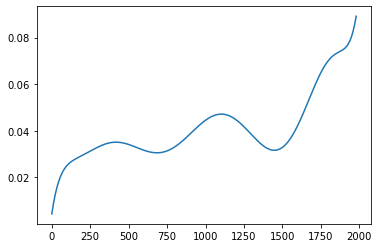

In [22]:
plt.plot(test_fit)

In [23]:
residuals = cat1_test - test_fit

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


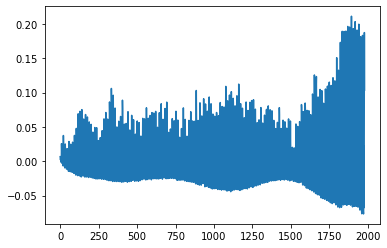

In [24]:
plt.plot(residuals)

#### "detrend" with filtering

Filter out frequencies higher than the annual (should remove the annual cycle, the seasonal cycle, etc)

In [61]:
fs=1 #1 month (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
low_cutoff=0.15# fraction of nyquist frequency, here  it is 5 days
hi_cutoff = 0.2
print('low cutoff= ',1/low_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
print('high cutoff= ',1/hi_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, low_cutoff , btype='lowpass') #low pass filter

low cutoff=  3.3333333333333335  months
high cutoff=  2.5  months


In [69]:
cat1_filtered = signal.filtfilt(b, a, cat1_test, axis = 0)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


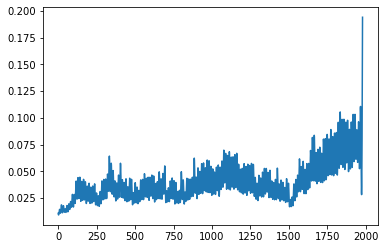

In [70]:
plt.plot(cat1_filtered)

Remove the high frequencies from the timeseries and visualize

In [71]:
separated = cat1_test - cat1_filtered

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


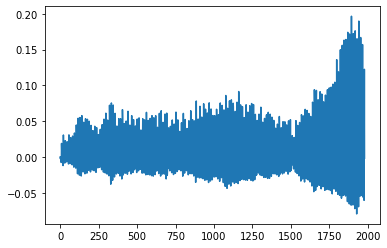

In [72]:
plt.plot(separated)

Perform a frequency analysis on the low frequency data

In [73]:
f0, Pxx0 = signal.welch(separated[10:-10], fs=1, window = 'hann', nperseg=128, detrend = 'linear', axis = 0)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


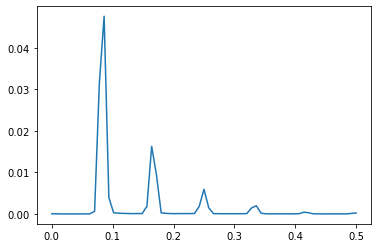

In [74]:
plt.plot(f0, Pxx0)
# plt.xlim([0, 0.1])

In [29]:
1/f0[11]

11.636363636363637

In [27]:
Pxx0

array([6.41073695e-05, 6.80886137e-05, 2.03396612e-06, 6.68577786e-07,
       1.34459646e-05, 2.20630279e-04, 1.71869891e-03, 4.02673600e-03,
       4.71325745e-03, 4.57756927e-03, 5.41474147e-02, 8.30729924e-02,
       9.49047783e-03, 2.71081993e-03, 3.18802854e-03, 2.93350110e-03,
       2.53672527e-03, 1.66570787e-03, 1.47262499e-03, 1.56050312e-03,
       2.10603277e-03, 1.19889375e-02, 8.13258526e-03, 1.36357349e-03,
       8.72564099e-04, 9.37923876e-04, 6.84127113e-04, 5.05793112e-04,
       5.01712011e-04, 4.05819469e-04, 4.87773696e-04, 1.60380067e-03,
       5.70859493e-03, 1.84573244e-03, 4.06486807e-04, 3.28252220e-04,
       4.02982228e-04, 2.61396231e-04, 1.87469694e-04, 2.88169631e-04,
       2.10879646e-04, 2.59290250e-04, 7.07443411e-04, 9.14273903e-04,
       2.75942136e-04, 2.31857418e-04, 2.05025036e-04, 1.59654039e-04,
       1.95742558e-04, 1.67270651e-04, 1.52327113e-04, 1.07922547e-04,
       1.03051741e-04, 2.29378128e-04, 1.70451913e-04, 9.99140811e-05,
      

In [39]:
test_day = cmip_mon_vol[:, 355, 193]

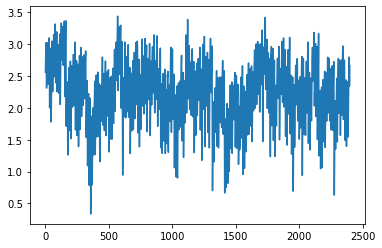

In [40]:
plt.plot(test_day)

Detrend the timeseries

In [43]:
test_day_detrend = signal.detrend(test_day, type = "linear")

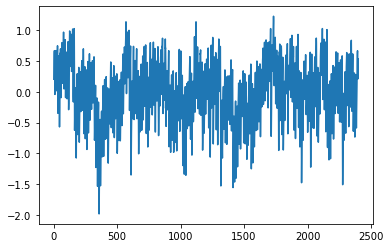

In [44]:
plt.plot(test_day_detrend)

Group by month and take the standard deviation

In [45]:
test_detrend_array = xr.DataArray(test_day_detrend, coords=test_day.coords, dims=test_day.dims, attrs=test_day.attrs)
test_detrend_array = test_detrend_array.where(test_detrend_array > 0)

In [47]:
test_detrend_array.var(dim='time')

<xarray.DataArray ()>
array(0.0610637)
Coordinates:
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>
    ni       int32 194
    nj       int32 356

Define a function for the above process to be applied to an entire 3d array

### Monthly Analysis (Full Test)

In [49]:
variance = annual_variance_per_season(cmip_mon_hi)

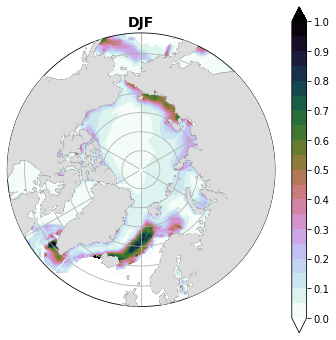

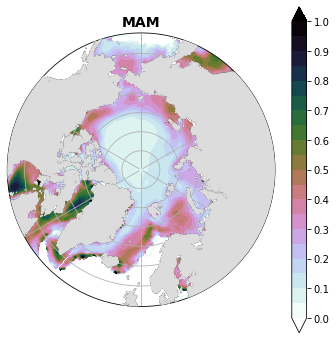

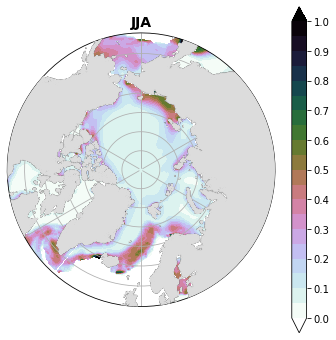

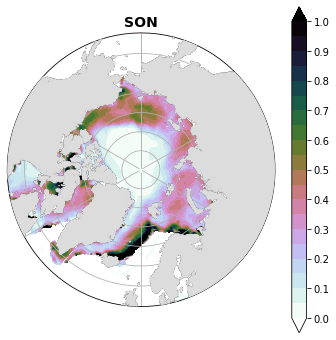

In [50]:
# months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
seasons = ['DJF','MAM','JJA','SON']

for i in range(0,4):
    plot_nps(variance[i], [0,1], plt.cm.cubehelix_r)
    plt.title(seasons[i], fontweight= 'bold', fontsize =14)

In [57]:
variance_day = annual_variance_per_season(cmip_day_hi)

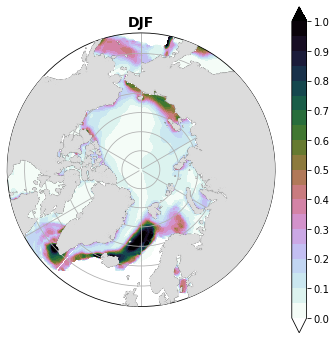

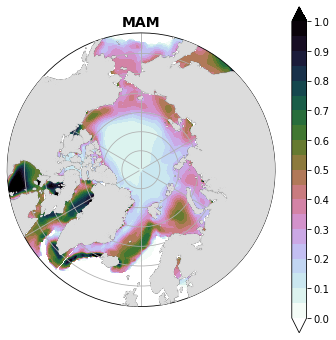

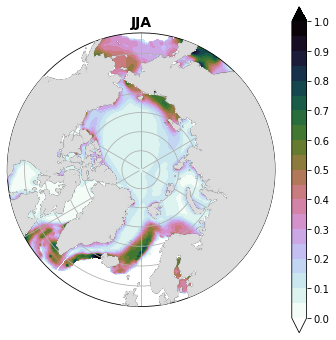

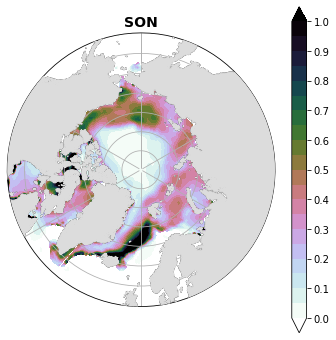

In [58]:
# months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
seasons = ['DJF','MAM','JJA','SON']

for i in range(0,4):
    plot_nps(variance_day[i], [0,1], plt.cm.cubehelix_r)
    plt.title(seasons[i], fontweight= 'bold', fontsize =14)

In [59]:
diff_variance = variance_day - variance

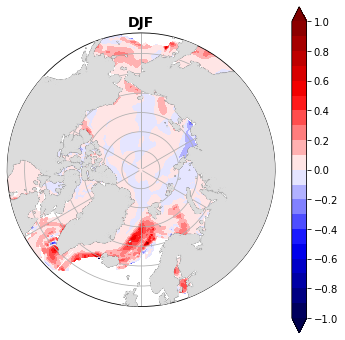

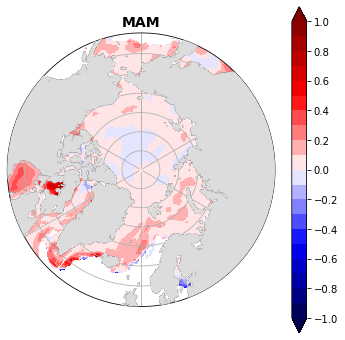

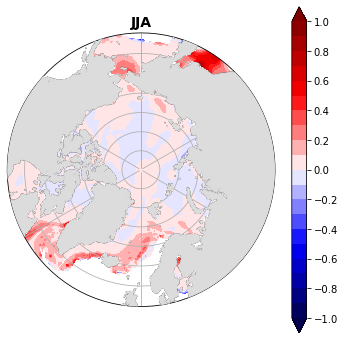

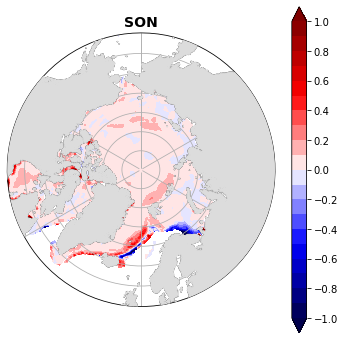

In [60]:
# months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
seasons = ['DJF','MAM','JJA','SON']

for i in range(0,4):
    plot_nps(diff_variance[i], [-1,1], plt.cm.seismic)
    plt.title(seasons[i], fontweight= 'bold', fontsize =14)

### Monthly Analysis By Category

### Daily Analysis

In [76]:
cat1_test = cesmle_vol[:,:, 355,193].mean(axis = 1)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


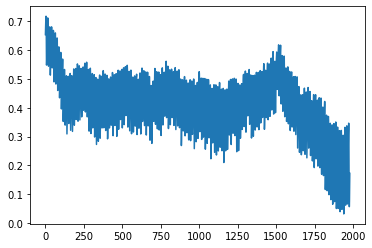

In [78]:
plt.plot(cat1_test)

In [100]:
fs=1 #1 month (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
low_cutoff=0.05# fraction of nyquist frequency, here  it is 5 days
hi_cutoff = 0.1
print('low cutoff= ',1/low_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
print('high cutoff= ',1/hi_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, [low_cutoff, hi_cutoff] , btype='bandpass') #low pass filter

low cutoff=  10.0  months
high cutoff=  5.0  months


In [101]:
cat1_filtered = signal.filtfilt(b, a, cat1_test, axis = 0)

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [102]:
var510 = cat1_filtered.var(axis=0)

In [85]:
var12

0.00042828020270071696

In [94]:
var25

0.004710892110773405

In [103]:
var510

4.108103242505363e-05